In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pickle

with open("/content/drive/MyDrive/20241/patrones/proyecto/DATA_seconds_bal_xy_tt_ol.pkl", "rb") as f:
    x_train, x_test, y_train, y_test, classes = pickle.load(f)

In [ ]:
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import pywt
from multiprocessing import Pool

def wavelet_transform(signal):
    # Perform Discrete Wavelet Transform (DWT) with the desired wavelet
    coeffs = pywt.wavedec(signal, wavelet='db1', level=None)
    # Select the first 10 coefficients from each level (excluding the approximation)
    selected_coeffs = []
    for c in coeffs[1:]:  # Skip the approximation coefficients
        selected_coeffs.extend(c[:10])  # Select the first 10 coefficients from each level

    return np.array(selected_coeffs)

# Function to process all signals using parallel processing
def process_signals(signals):
    with Pool() as pool:
        results = pool.map(wavelet_transform, signals)
    return results

In [ ]:
x_train = np.array(process_signals(x_train))
x_test = np.array(process_signals(x_test))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
import matplotlib.pyplot as plt
def plotaccloss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 6))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r*-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the input data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [ ]:
nout=len(classes)

In [ ]:
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM, Bidirectional, Reshape, GRU,Dropout,BatchNormalization
from tensorflow.keras.regularizers import l1

# strategy = tf.distribute.TPUStrategy(resolver)

# Define the model inside the strategy scope
# with strategy.scope():
model = Sequential()
model.add(Input(shape=(114,)))

# Add Dense layers to build a DNN
model.add(Dense(512, activation='relu', kernel_regularizer=l1(0.01)))
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01)))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l1(0.01)))
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l1(0.01)))
# model.add(Dropout(0.2))

# Output layer
model.add(Dense(nout, activation='softmax'))

# Compile the model
if nout == 2:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Summarize the model
# model.summary()

Epoch 1/100
474/474 [==============================] - 5s 7ms/step - loss: 10.7252 - accuracy: 0.2454 - val_loss: 1.6776 - val_accuracy: 0.2420
Epoch 2/100
474/474 [==============================] - 2s 5ms/step - loss: 1.6769 - accuracy: 0.2467 - val_loss: 1.6769 - val_accuracy: 0.2435
Epoch 3/100
474/474 [==============================] - 2s 4ms/step - loss: 1.6769 - accuracy: 0.2476 - val_loss: 1.6771 - val_accuracy: 0.2435
Epoch 4/100
474/474 [==============================] - 2s 4ms/step - loss: 1.6769 - accuracy: 0.2518 - val_loss: 1.6783 - val_accuracy: 0.2435
Epoch 5/100
474/474 [==============================] - 2s 4ms/step - loss: 1.6769 - accuracy: 0.2453 - val_loss: 1.6778 - val_accuracy: 0.2420
Epoch 6/100
474/474 [==============================] - 3s 5ms/step - loss: 1.6769 - accuracy: 0.2506 - val_loss: 1.6775 - val_accuracy: 0.2435
Epoch 7/100
474/474 [==============================] - 3s 6ms/step - loss: 1.6769 - accuracy: 0.2478 - val_loss: 1.6770 - val_accuracy: 0.243

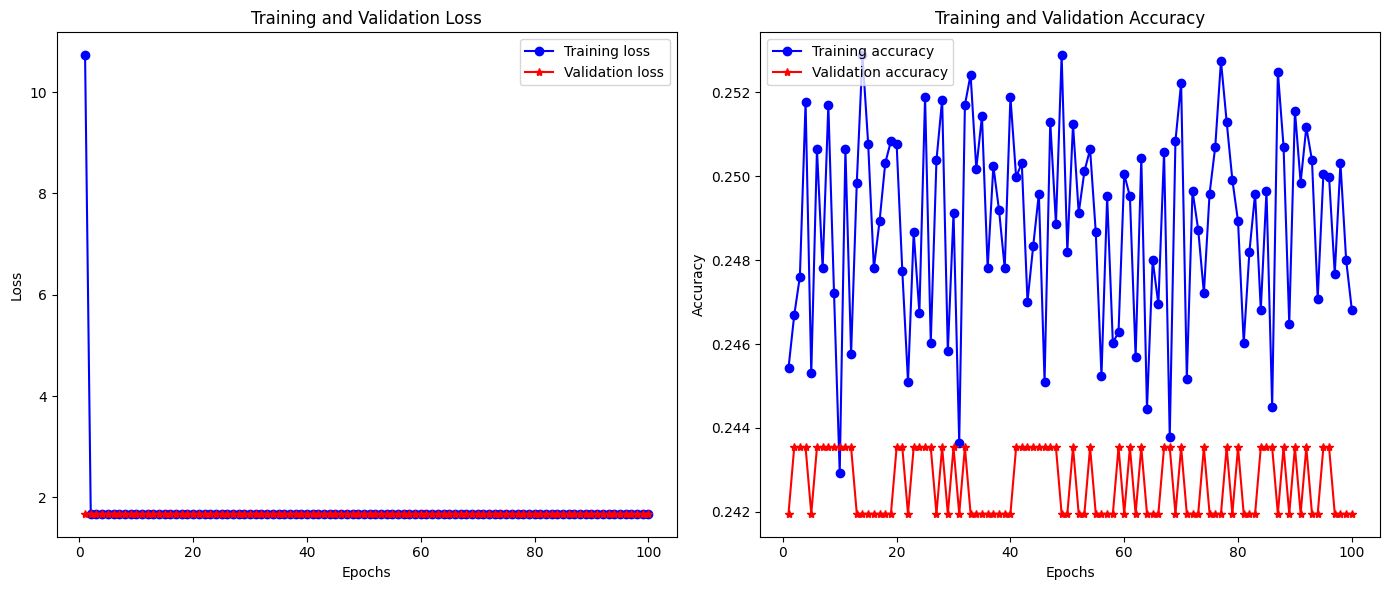

In [ ]:
# Train the model
history = model.fit(x_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)
plotaccloss(history)

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

149/149 [==============================] - 0s 3ms/step - loss: 1.6762 - accuracy: 0.2499
Test Accuracy: 0.2499


In [ ]:
y_pred_prob = model.predict(x_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

149/149 [==============================] - 0s 2ms/step


<Figure size 1000x800 with 0 Axes>

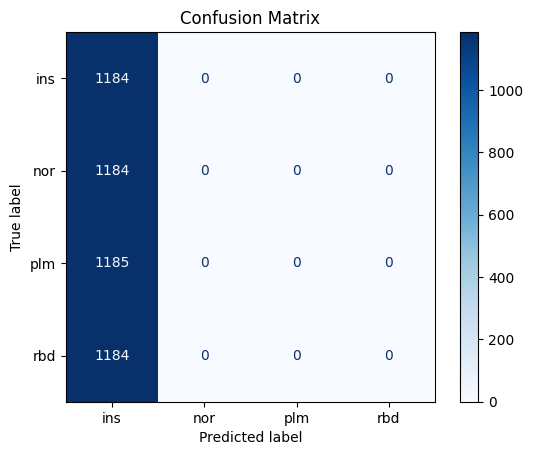

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()